In [30]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates
import matplotlib.dates as mdates
import calendar

In [31]:
bjg_df = pd.read_csv('data/beijing, west park.csv').dropna() # Capital city
pzh_df = pd.read_csv('data/panzhihua.csv') # Steel industry
szh_df = pd.read_csv('data/shuozhou.csv') # Coal center, Shanxi
tyn_df = pd.read_csv('data/taiyuan.csv') # Shanxi's capital city
btu_df = pd.read_csv('data/baotou.csv') # REE mining at Bayan Obo
gzh_df = pd.read_csv('data/ganzhou.csv')
tsh_df = pd.read_csv('data/tangshan.csv')

In [32]:
list_df = [bjg_df, pzh_df, szh_df, tyn_df, btu_df, gzh_df, tsh_df] # Update as needed
list_df_new=[]

for df in list_df:
    data = df.copy()
    data.date = pd.to_datetime(data.date)
    data = data.sort_values(by='date', ascending=False)

    data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    for col in data.columns:
        if col != "date":
            data[col] = pd.to_numeric(data[col], errors='coerce')

    list_df_new.append(data)

[bjg_df, pzh_df, szh_df, tyn_df, btu_df, gzh_df, tsh_df] = list_df_new # Update as needed


/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_41005/1048996481.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.date = pd.to_datetime(data.date)


In [33]:
from dateutil.parser import parse     # package for date parsing
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})  # increase dots per inch ...

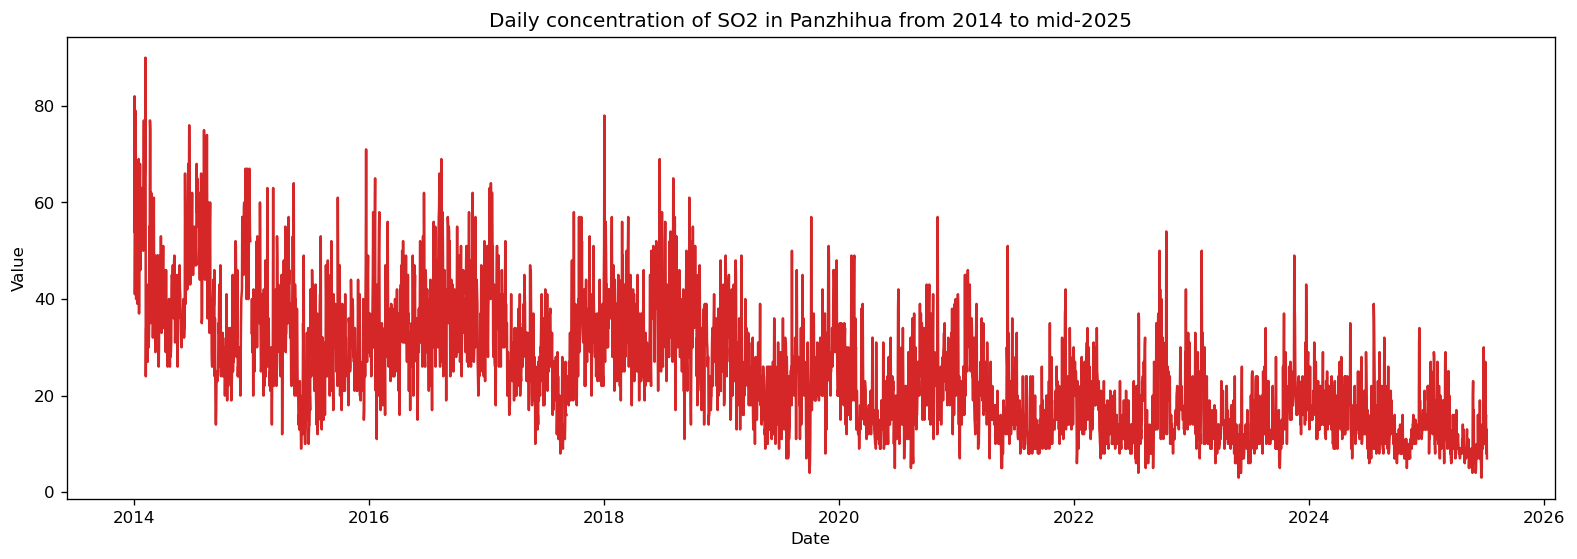

In [34]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(pzh_df, x=pzh_df.date, y=pzh_df.SO2, title='Daily concentration of SO2 in Panzhihua from 2014 to mid-2025')

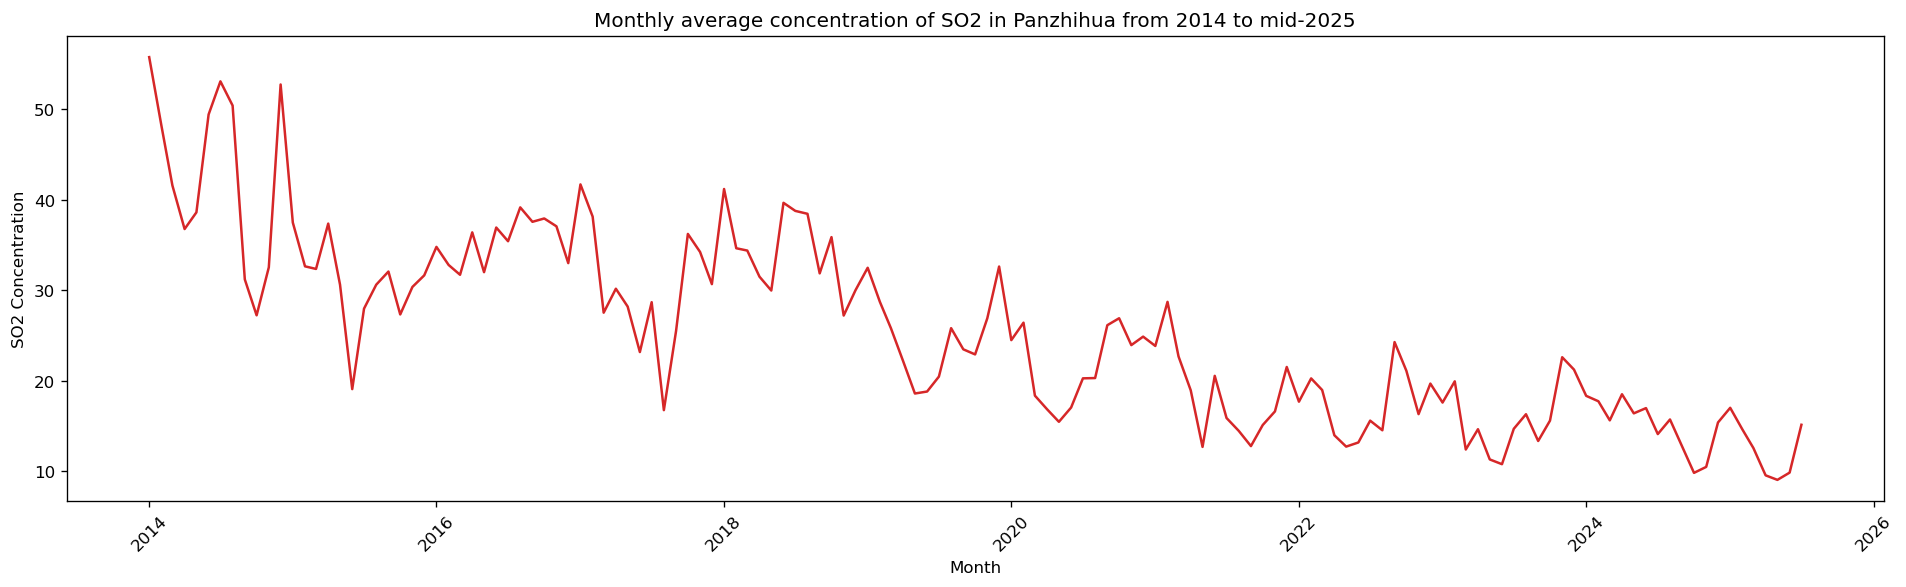

In [35]:
# Convert date to monthly period, then back to Timestamp for plotting
def monthlyAverage(df, city_name, pollutant):
    monthly_df = df.copy()
    monthly_df['year_month'] = monthly_df.date.dt.to_period('M').dt.to_timestamp()

    # Group by the new monthly date
    monthly_avg = monthly_df.groupby('year_month')[pollutant].mean().reset_index()

    def plot_df(x, y, title="", xlabel='Date', ylabel='Value'):
        plt.figure(figsize=(16, 5))
        plt.plot(x, y, color='tab:red')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    plot_df(
        x=monthly_avg['year_month'],
        y=monthly_avg[pollutant],
        title='Monthly average concentration of {pollutant} in {city_name} from 2014 to mid-2025'.format(pollutant=pollutant, city_name=city_name),
        xlabel='Month',
        ylabel='{pollutant} Concentration'.format(pollutant=pollutant)
)

monthlyAverage(pzh_df, 'Panzhihua', 'SO2')

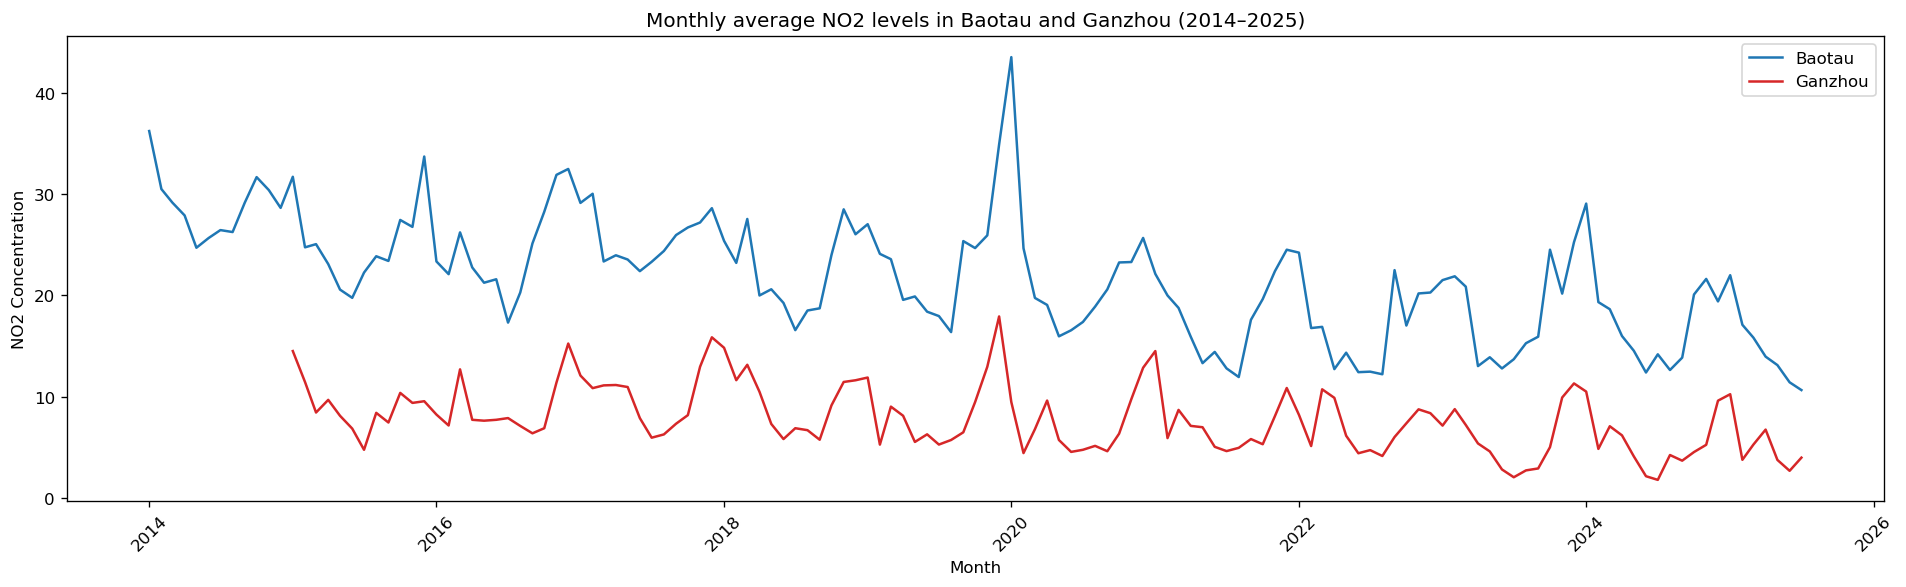

In [36]:
def compareMonthlyAverages(df1, city1, df2, city2, pollutant):
    # Create copies
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    # Convert to monthly timestamps
    df1_copy['year_month'] = df1_copy.date.dt.to_period('M').dt.to_timestamp()
    df2_copy['year_month'] = df2_copy.date.dt.to_period('M').dt.to_timestamp()

    # Group and average
    avg1 = df1_copy.groupby('year_month')[pollutant].mean().reset_index()
    avg2 = df2_copy.groupby('year_month')[pollutant].mean().reset_index()

    # Plot
    plt.figure(figsize=(16, 5))
    plt.plot(avg1['year_month'], avg1[pollutant], label=city1, color='tab:blue')
    plt.plot(avg2['year_month'], avg2[pollutant], label=city2, color='tab:red')

    plt.title(f'Monthly average {pollutant} levels in {city1} and {city2} (2014–2025)')
    plt.xlabel('Month')
    plt.ylabel(f'{pollutant} Concentration')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

compareMonthlyAverages(btu_df, 'Baotau', gzh_df, 'Ganzhou', 'NO2')

In [37]:
def seasonalityPlot(df, city_name, pollutant):
# Create 'year' and 'month' columns
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['month_abbr'] = df.date.dt.strftime('%b')

    # Get month order
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Aggregate: average SO2 per month per year
    monthly_avg = df.groupby(['year', 'month'])[pollutant].mean().reset_index()
    monthly_avg['month_abbr'] = monthly_avg['month'].apply(lambda x: month_order[x - 1])

    # Get unique years
    years = sorted(monthly_avg['year'].unique())

    # Random colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

    # Plot
    plt.figure(figsize=(16, 10))

    for i, y in enumerate(years):
        year_data = monthly_avg[monthly_avg.year == y]
        plt.plot(
            year_data['month_abbr'],
            year_data[pollutant],
            color=mycolors[i],
            label=y
        )
        
        # Add year label at the end
        last_x = year_data['month_abbr'].values[-1]
        last_y = year_data[pollutant].values[-1]
        plt.text(
            x=11.2,  # right of December
            y=last_y,
            s=str(y),
            color=mycolors[i],
            fontsize=9,
            va='center'
        )

    # Final styling
    plt.xticks(ticks=range(12), labels=month_order, fontsize=12)
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Month', fontsize=13)
    plt.ylabel('{pollutant} Concentration'.format(pollutant=pollutant), fontsize=13)
    plt.title('Seasonal Plot of {pollutant} Concentration in {city_name}'.format(pollutant=pollutant, city_name=city_name), fontsize=18)
    plt.grid(alpha=0.3)
    plt.xlim(-0.3, 11.5)
    plt.tight_layout()
    plt.show()

# for col in btu_df.columns:
#     if col != 'date':
#         for df in list_df_new:
#             seasonalityPlot(df, df.head(1), col)

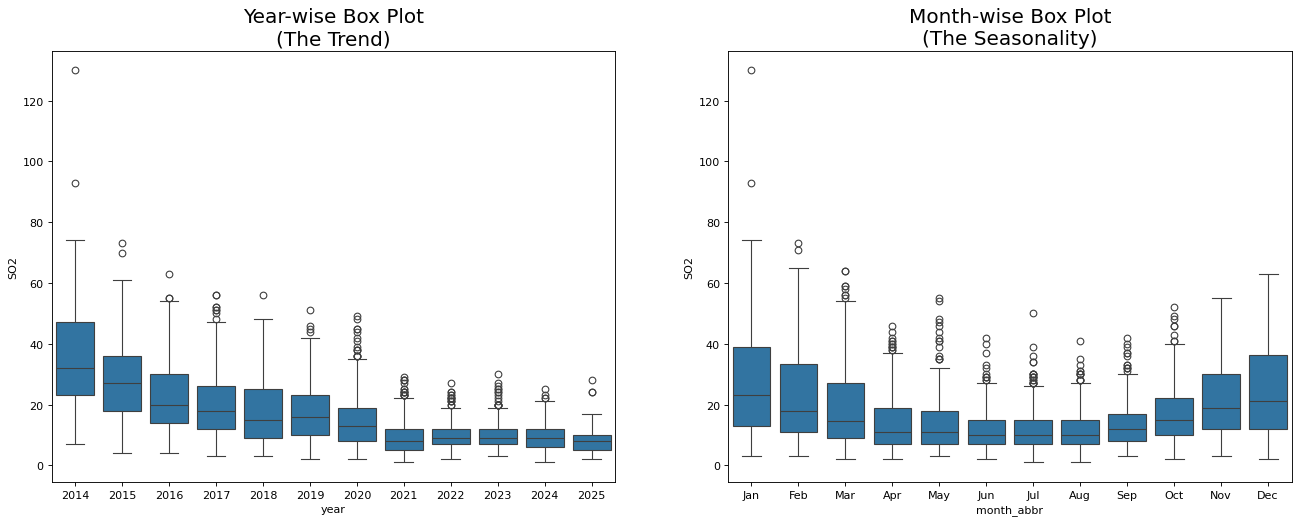

In [38]:
def boxPlot(df, pollutant):
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['month_abbr'] = df.date.dt.strftime('%b')
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y=pollutant, data=df, ax=axes[0])
    sns.boxplot(x='month_abbr', y=pollutant, data=df.loc[~df.year.isin([2013, 2026]), :], order=month_order)

    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()

boxPlot(btu_df, 'SO2')

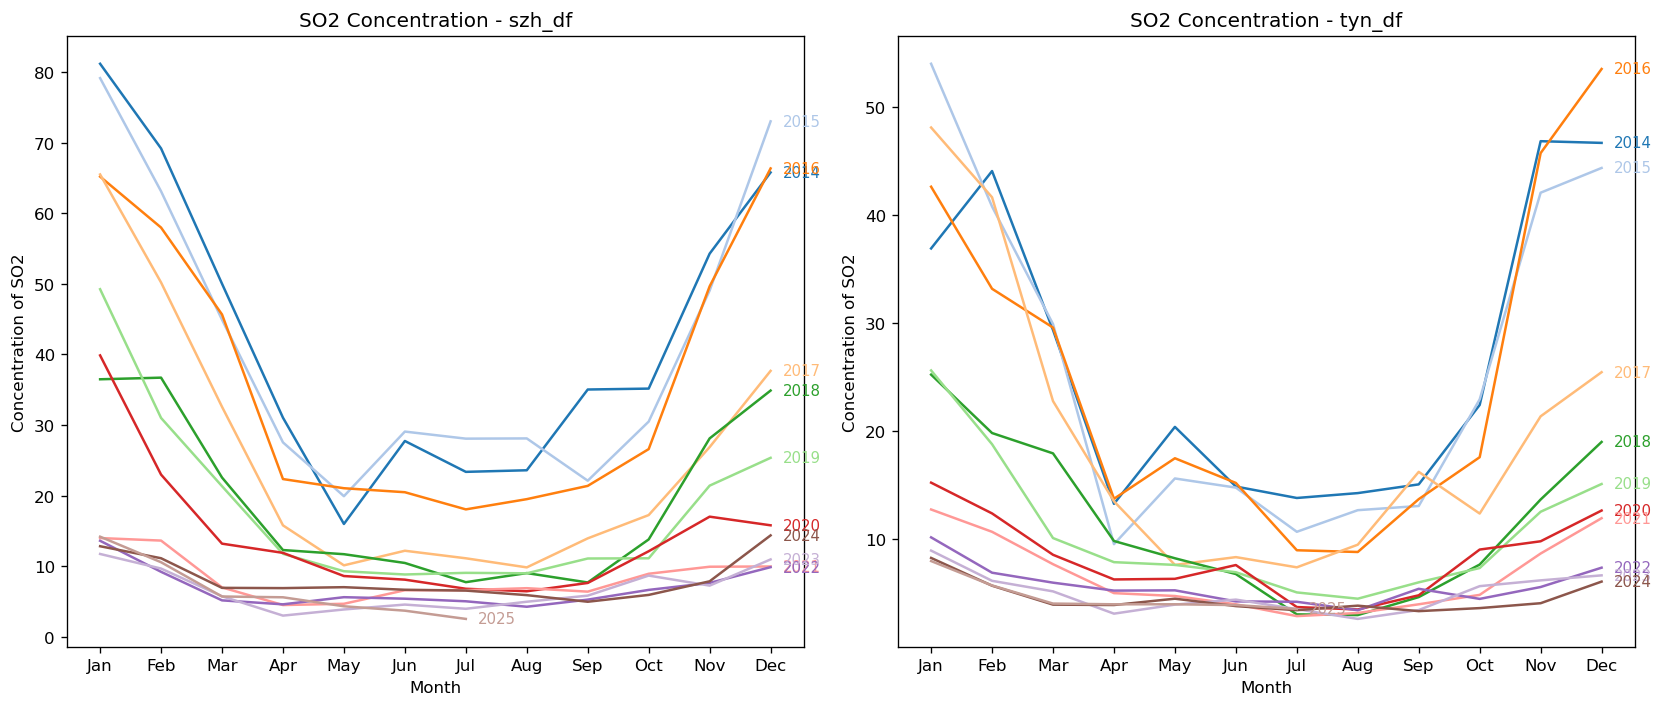

In [39]:
# Comparative plots

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

num_years_szh = len(szh_df.date.dt.year.unique())
num_years_tyn = len(tyn_df.date.dt.year.unique())

palette_szh = sns.color_palette("tab20", num_years_szh)
palette_tyn = sns.color_palette("tab20", num_years_tyn)

# First plot: szh_df
for i, year in enumerate(sorted(szh_df.date.dt.year.unique())):
    data = szh_df[szh_df.date.dt.year == year]
    monthly = data.groupby(data.date.dt.month)['SO2'].mean()
    sns.lineplot(x=monthly.index, y=monthly.values, color=palette_szh[i], ax=ax[0])
    
    # Annotate at end of line
    ax[0].text(
        x=monthly.index.max() + 0.2,  # a little to the right of last point
        y=monthly.values[-1],
        s=str(year),
        color=palette_szh[i],
        va='center',
        fontsize=9
    )

ax[0].set_title('SO2 Concentration - szh_df')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Concentration of SO2')
ax[0].set_xticks(range(1, 13))
ax[0].set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])

# Second plot: tyn_df
for i, year in enumerate(sorted(tyn_df.date.dt.year.unique())):
    data = tyn_df[tyn_df.date.dt.year == year]
    monthly = data.groupby(data.date.dt.month)['SO2'].mean()
    sns.lineplot(x=monthly.index, y=monthly.values, color=palette_tyn[i], ax=ax[1])
    
    # Annotate at end of line
    ax[1].text(
        x=monthly.index.max() + 0.2,
        y=monthly.values[-1],
        s=str(year),
        color=palette_tyn[i],
        va='center',
        fontsize=9
    )

ax[1].set_title('SO2 Concentration - tyn_df')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Concentration of SO2')
ax[1].set_xticks(range(1, 13))
ax[1].set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])

# No legends needed
plt.tight_layout()
plt.show()

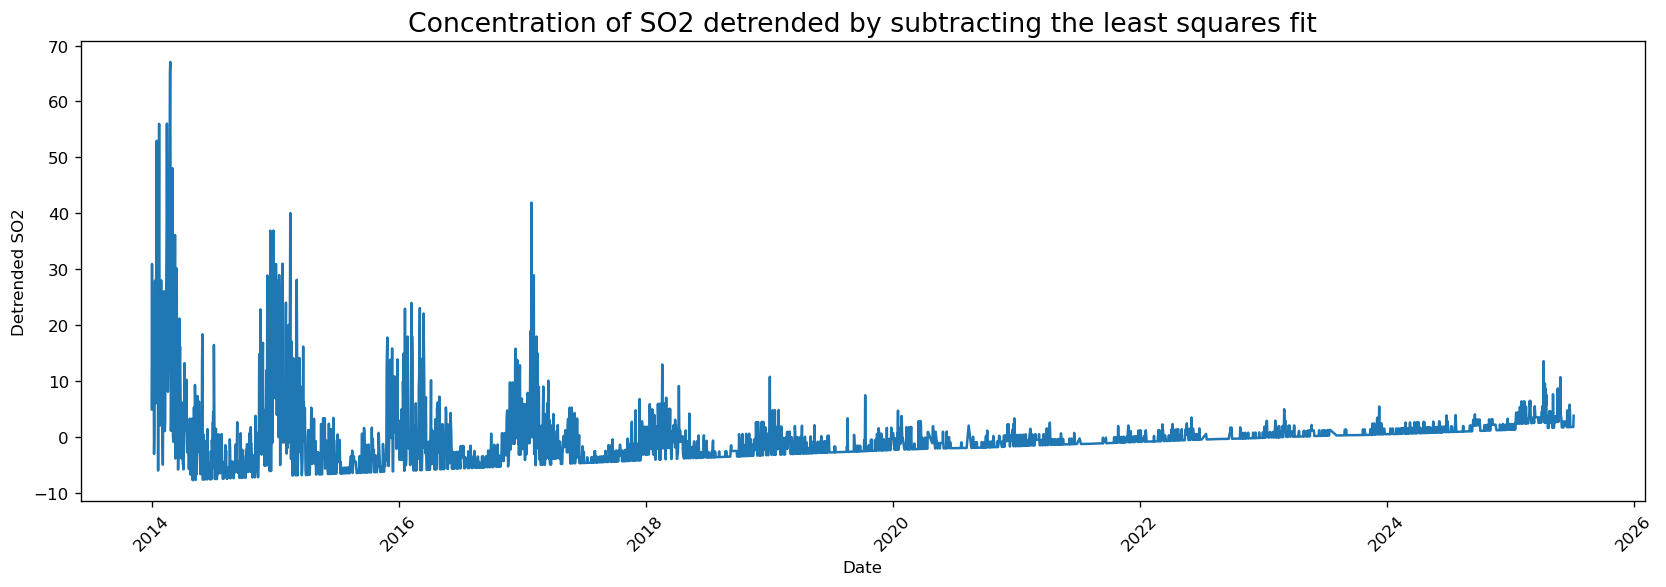

In [40]:
from scipy import signal

# Drop rows where SO2 is NaN and keep both date and SO2
cleaned = bjg_df[['date', 'SO2']].dropna()

# Detrend the SO2 values
detrended = signal.detrend(cleaned['SO2'].values)

# Plot with proper datetime x-axis
plt.figure(figsize=(14, 5))
plt.plot(cleaned['date'], detrended)
plt.title('Concentration of SO2 detrended by subtracting the least squares fit', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Detrended SO2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

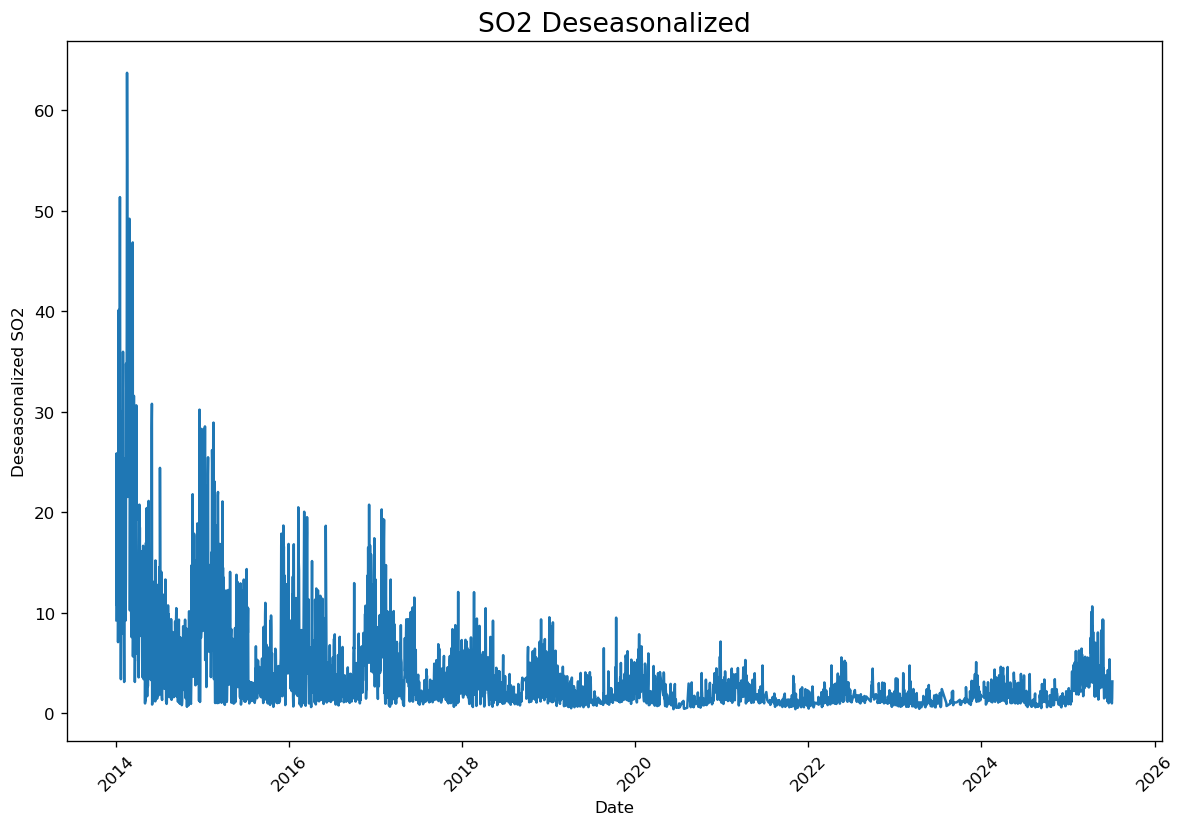

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Drop NA and set 'date' as index
cleaned = bjg_df[['date', 'SO2']].dropna()
cleaned['date'] = pd.to_datetime(cleaned['date'])  # Ensure datetime
cleaned = cleaned.set_index('date')

# Resample daily and drop NaNs
cleaned = cleaned.asfreq('D').dropna()

# Decompose with explicit period (e.g., 365 for yearly seasonality)
result_mul = seasonal_decompose(cleaned['SO2'], model='multiplicative', period=365, extrapolate_trend='freq')

# Deseasonalize
deseasonalized = cleaned['SO2'] / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('SO2 Deseasonalized', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Deseasonalized SO2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Next step:
# What is happening in Baotou in January 2020 for a high spike in NO2?
# What is happening with SO2 level in Panzhihua?